In [18]:
import pandas as pd
import networkx as nx

In [19]:
interactions_data = pd.read_csv('ona_interactions_hierarchical.csv')

In [20]:
employees_data = pd.read_csv('ona_employees_hierarchical.csv')

In [21]:
G = nx.DiGraph()

for _, row in employees_data.iterrows():
    G.add_node(
        row['EmployeeID'],
        level=row['Level'],
        department=row['Department'],
        title=row['Title'],
        manager=row['ManagerID']
    )

for _, row in interactions_data.iterrows():
    sender = row['SenderID']
    receiver = row['ReceiverID']
    weight = row['InteractionWeight']
    
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += weight
    else:
        G.add_edge(sender, receiver, weight=weight, channel=row['Channel'])

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 200
Number of edges: 9431


In [22]:

degree_centrality = nx.degree_centrality(G)
in_degree = dict(G.in_degree(weight='weight'))
out_degree = dict(G.out_degree(weight='weight'))

betweenness = nx.betweenness_centrality(G, weight='weight')
closeness = nx.closeness_centrality(G)
pagerank = nx.pagerank(G, weight='weight')

centrality_df = pd.DataFrame({
    'EmployeeID': list(G.nodes()),
    'DegreeCentrality': [degree_centrality[n] for n in G.nodes()],
    'InDegree': [in_degree.get(n, 0) for n in G.nodes()],
    'OutDegree': [out_degree.get(n, 0) for n in G.nodes()],
    'Betweenness': [betweenness[n] for n in G.nodes()],
    'Closeness': [closeness[n] for n in G.nodes()],
    'PageRank': [pagerank[n] for n in G.nodes()]
})

centrality_df = centrality_df.merge(employees_data, on='EmployeeID')

centrality_df.sort_values(by='PageRank', ascending=False).head(10)

,EmployeeID,DegreeCentrality,InDegree,OutDegree,Betweenness,Closeness,PageRank,Level,Department,Title,ManagerID
2,E0003,0.261307,386,185,0.002182,0.560563,0.013857,VP,HR,VP,E0001
6,E0007,0.291457,320,146,0.000000,0.568571,0.013776,Director,Finance,Director,E0003
9,E0010,0.316583,345,163,0.004618,0.562147,0.013382,Manager,HR,Manager,E0005
21,E0022,0.316583,334,174,0.000000,0.566952,0.013151,Manager,Marketing,Manager,E0005
3,E0004,0.291457,280,174,0.004289,0.568571,0.012968,Director,Operations,Director,E0003
7,E0008,0.341709,340,171,0.000000,0.570201,0.012712,Manager,Finance,Manager,E0005
1,E0002,0.236181,319,200,0.000025,0.555866,0.012600,VP,HR,VP,E0001
5,E0006,0.281407,285,126,0.000000,0.573487,0.012459,Director,Finance,Director,E0003
16,E0017,0.301508,305,194,0.000000,0.560563,0.011871,Manager,HR,Manager,E0005
14,E0015,0.316583,332,193,0.000000,0.566952,0.011443,Manager,Marketing,Manager,E0007


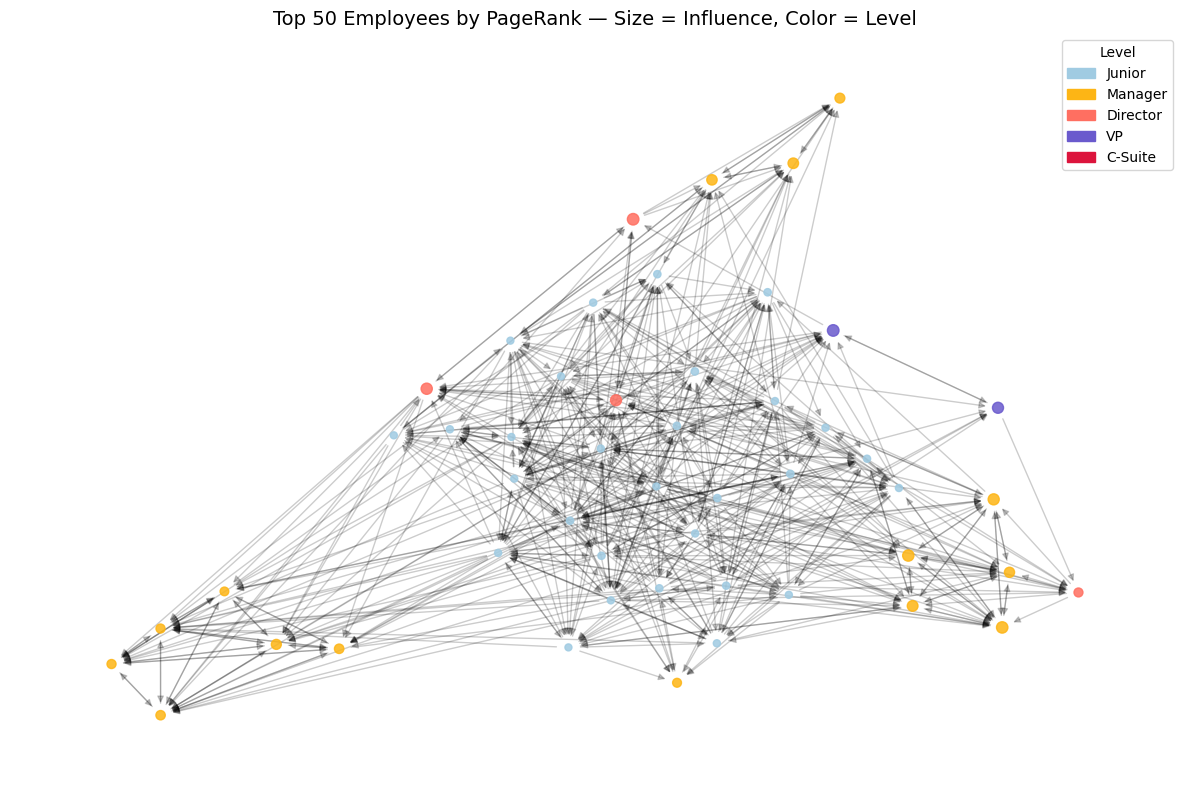

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

ceo_id = employees_data[employees_data['Title'] == 'CEO']['EmployeeID'].iloc[0]

top_n = 50
top_nodes = centrality_df.nlargest(top_n, 'PageRank')['EmployeeID'].tolist()

subG = G.subgraph(top_nodes)

pagerank_values = {n: pagerank[n] for n in subG.nodes()}
levels = nx.get_node_attributes(G, 'level')

color_map = {
    'Junior': '#A0CBE2',
    'Manager': '#FDB515',
    'Director': '#FF6F61',
    'VP': '#6A5ACD',
    'C-Suite': '#DC143C'
}
ceo_color = '#000000' 

node_colors = [
    ceo_color if n == ceo_id else color_map.get(levels.get(n, ''), '#CCCCCC')
    for n in subG.nodes()
]
node_sizes = [5000 * pagerank_values[n] for n in subG.nodes()]  

pos = nx.spring_layout(subG, k=0.5, seed=42)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=node_sizes, alpha=0.85)
nx.draw_networkx_edges(subG, pos, alpha=0.2, arrows=True)

legend_patches = [mpatches.Patch(color=color, label=level) for level, color in color_map.items()]
plt.legend(handles=legend_patches, title="Level", loc="best")

plt.title("Top 50 Employees by PageRank — Size = Influence, Color = Level", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
top_pct = 0.05
n_top = int(len(centrality_df) * top_pct)

top_pagerank = centrality_df.nlargest(n_top, 'PageRank')['EmployeeID']
top_betweenness = centrality_df.nlargest(n_top, 'Betweenness')['EmployeeID']
top_closeness = centrality_df.nlargest(n_top, 'Closeness')['EmployeeID']

centrality_df['HighPotential_Structural'] = centrality_df['EmployeeID'].isin(
    pd.concat([top_pagerank, top_betweenness, top_closeness])
).astype(int)

centrality_df['HiddenHighPotential'] = centrality_df.apply(
    lambda row: 1 if row['HighPotential_Structural'] == 1 and row['Level'] not in ['VP', 'C-Suite'] else 0,
    axis=1
)

In [25]:
summary_by_level = centrality_df.groupby('Level').agg(
    Total=('EmployeeID', 'count'),
    HighPotentials=('HighPotential_Structural', 'sum'),
    HiddenHighPotentials=('HiddenHighPotential', 'sum')
).reset_index()

summary_by_level['Pct_HighPotentials'] = summary_by_level['HighPotentials'] / summary_by_level['Total']
summary_by_level['Pct_HiddenHighPotentials'] = summary_by_level['HiddenHighPotentials'] / summary_by_level['Total']

summary_by_level

,Level,Total,HighPotentials,HiddenHighPotentials,Pct_HighPotentials,Pct_HiddenHighPotentials
0,C-Suite,1,0,0,0.000000,0.000000
1,Director,4,3,3,0.750000,0.750000
2,Junior,178,14,14,0.078652,0.078652
3,Manager,15,9,9,0.600000,0.600000
4,VP,2,2,0,1.000000,0.000000


In [26]:
from sklearn.preprocessing import normalize
import numpy as np

centrality_full = centrality_df.merge(employees_data, on='EmployeeID')

leaders = centrality_full[
    (centrality_full['Level_y'] == 'VP') | 
    (centrality_full['Title_y'] == 'CEO')
]

centrality_cols = ['PageRank', 'Betweenness', 'Closeness']

leader_profile = leaders[centrality_cols].mean().values.reshape(1, -1)

leader_profile = normalize(leader_profile)

print("Leader profile vector (normalized):", leader_profile)

Leader profile vector (normalized): [[0.01858121 0.00131077 0.9998265 ]]


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

non_execs = centrality_full[
    (centrality_full['Level_y'] != 'VP') & 
    (centrality_full['Title_y'] != 'CEO')
].copy()

non_exec_metrics = non_execs[centrality_cols].values
non_exec_metrics_norm = normalize(non_exec_metrics)

similarities = cosine_similarity(non_exec_metrics_norm, leader_profile).flatten()

non_execs['SimilarityToLeader'] = similarities

top_similar = non_execs.sort_values('SimilarityToLeader', ascending=False).head(10)
top_similar[['EmployeeID', 'Level_y', 'Title_y', 'SimilarityToLeader']]

,EmployeeID,Level_y,Title_y,SimilarityToLeader
17,E0018,Manager,Manager,1.000000
11,E0012,Manager,Manager,0.999999
8,E0009,Manager,Manager,0.999999
14,E0015,Manager,Manager,0.999998
16,E0017,Manager,Manager,0.999996
5,E0006,Director,Director,0.999994
12,E0013,Manager,Manager,0.999993
7,E0008,Manager,Manager,0.999992
19,E0020,Manager,Manager,0.999992
13,E0014,Manager,Manager,0.999991
